In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean

In [2]:
city = 'Kolkata'
month = 'July'
PATH = f'/media/root/data/analysis/data/Item_wise_data/{city}/'
t100 = time.time()

In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

/tmp/ipykernel_240321/70406848.py:2: DtypeWarning: Columns (4,5,8,12,13,18,20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH+f'{month}.csv')


In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Driver_Shift', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = round(df['prep_time']/np.timedelta64(1, 's')).astype(int) + 7*60
print(df.shape)
df.head()

(619120, 27)
(619120, 7)


ParserError: Unknown string format: DPI67075

In [5]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()
# allMenuCodes, allStoreIds

(array(['PIZ0200', 'PIZ5106', 'PIZ0121', 'PIZ0120', 'PIZ0130', 'PIZ0129',
        'PIZ0131', 'PIZ0133', 'PIZ0117', 'PIZ0134', 'PIZ0165', 'BRD0020',
        'CAKE02', 'BRD0031', 'NVPARCEL', 'SID0069', 'SID0046', 'PIZ0140',
        'PIZ0132', 'PIZ5126', 'PIZ5155', 'NVPARCL2', 'PIZ0125', 'TACVG05',
        'PIZ0172', 'PIZ5144', 'BRD0033', 'PIZ0191', 'PIZ0193', 'PIZ0206',
        'PIZ0192', 'PIZ5135', 'PIZ0179', 'PIZ0119', 'BRD0024', 'PIZ0124',
        'PIZ5122', 'PIZ0127', 'PIZ0148', 'BRD0030', 'VGPARCEL', 'PIZ0162',
        'SID0060', 'SID0063', 'TACNV06', 'PIZ5156', 'PIZ0195', 'PIZ0197',
        'PIZ0164', 'PIZ0128', 'PIZ0194', 'PIZ5157', 'SID0059', 'PIZ0177',
        'PIZ0196', 'CAKE06', 'PIZ0118', 'PIZ5124', 'PIZ0170', 'TACVG04',
        'PIZ5109', 'SID0057', 'PIZ0171', 'BRD0032', 'TACVG07', 'SID0035',
        'PIZ5127', 'PIZ5119', 'PIZ0150', 'PIZ0201', 'BRD0035', 'PIZ0207',
        'PIZ0178', 'PIZ0184', 'SID0058', 'CAKE05', 'VGPARCL2', 'PIZ0174',
        'PIZ0126', 'SID0077', 'SID003

In [6]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [7]:
sampleItem

Location_Code                              DPI66576
Order_Date                      2022-07-01 00:00:00
Order_Number                                      1
Kitchen_Display_Time     2022-07-01 11:06:45.417000
Oven_Time                2022-07-01 11:07:26.867000
Menu_Code                                   PIZ0200
Item Description        Corn n Cheese Paratha Pizza
Quantity                                        1.0
Delivery_Time                                   NaN
prep_time                                       461
Name: 92935, dtype: object

In [8]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if(stores[i] == storeId):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        return [item['Location_Code']]

In [9]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

['DPI66576']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
# Feature 2: Item Type
def getOneHotEncodingItem(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodingItem(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if (items[i] == item):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, isOneHotEncodingRequired=False, clubCategoryWise=False):
    if (not isOneHotEncodingRequired):
        if clubCategoryWise:
            return [item['Menu_Code'][0:3]]
        return [item['Menu_Code']]
    else:
        return getOneHotEncodingItem(item['Menu_Code'], allMenuCodes, clubCategoryWise)

In [11]:
print(getItemType(sampleItem))
print(getItemType(sampleItem, True))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True, True))

['PIZ0200']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['PIZ']
[1, 0, 0, 0, 0, 0, 0]


In [12]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if isOneHotEncodingRequired:
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [timeslot]

In [13]:
def get_preparation_time(item):
    return item['prep_time']
# 	diff = item['Oven_Time'] - item['Kitchen_Display_Time']
# 	return diff.total_seconds() + 7*60

In [14]:
#DON"T RUN IT AGAIN AND AGAIN, it will take much more time
# Feature 4 : Count of all baking items of all orders received by the store in the last 20 minutes.

# Pre-preparation of data
df['pre_prep_time'] = 0

StoreWiseItems = {}
for index, item in df.iterrows():
    store = item['Location_Code']
    if store in StoreWiseItems:
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTime = dtKitchenDisplay - timedelta(minutes=60)
        count = 0
        pt = 0
        for i in reversed(range(len(StoreWiseItems[store]))):
            if(StoreWiseItems[store][i]['Kitchen_Display_Time'] >= lastTime and StoreWiseItems[store][i]['Kitchen_Display_Time'] < dtKitchenDisplay):
                if(StoreWiseItems[store][i]['Menu_Code'] == item['Menu_Code']):
                    pt += get_preparation_time(item)
                    count+=1
            else:
                break
        if count != 0:
            df['pre_prep_time'][index] = pt/count
        else:
            df['pre_prep_time'][index] = 10*60
        StoreWiseItems[store].append(item)
    else:
        StoreWiseItems[store] = [item]
        df['pre_prep_time'][index] = 10*60

        
storeWiseCumulativeItems = {}
StoreWiseDFs = {}
for store in StoreWiseItems.keys():
    StoreWiseDFs[store] = pd.DataFrame.from_dict(StoreWiseItems[store])
    storeWiseCumulativeItems[store] = {}

# item count per slot
for store in StoreWiseItems.keys():
    for item in StoreWiseItems[store]:
        date = item['Order_Date']
        minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
        if date in storeWiseCumulativeItems[store]:
            storeWiseCumulativeItems[store][date][minuteSlot]+=1
        else:
            t = []
            for i in range(0, 24*60):
                t.append(0)
            storeWiseCumulativeItems[store][date] = t
            storeWiseCumulativeItems[store][date][minuteSlot] = 1
            
#prefix sum            
for store in storeWiseCumulativeItems.keys():
    for date in storeWiseCumulativeItems[store].keys():
        for i in range(1, 24*60):
            storeWiseCumulativeItems[store][date][i] += storeWiseCumulativeItems[store][date][i-1]
            
            
def countPastOrders(item, storeWiseCumulativeItems=storeWiseCumulativeItems, slotTime=30):
    minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
    total = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][minuteSlot]
    prev = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][max(minuteSlot-slotTime, 0)]
    return [(total-prev)]

/tmp/ipykernel_236661/2016951000.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_236661/2016951000.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_236661/2016951000.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = pt/count


In [15]:
print("time = StoreWiseItems and countPastOrders", time.time()-t100)

# print(countPastOrders(sampleItem))
# print(countPastOrders(sampleItem, slotTime=10))

d = datetime.strptime('2021-12-20 00:00:00', '%Y-%m-%d %H:%M:%S')
# storeWiseCumulativeItems[sampleItem['Location_Code']][d]

[1]
[1]


In [16]:
# type(StoreWiseItems[sampleItem['Location_Code']])

list

In [17]:
# Feature 5 : Avg prep time of the same item in the same store in last 60 minutes.

def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
    orderedItem = item['Menu_Code']
    prepTime = []
    if clubCategoryWise:
        orderedItem = orderedItem[0:3]
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
             & (d['Kitchen_Display_Time'] >= lastTime) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]

    if(len(tdf)>0):
        return [tdf['prep_time'].mean()]
    else:
        return [10*60]


# def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
#     dtKitchenDisplay = item['Kitchen_Display_Time']
#     lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
#     orderedItem = item['Menu_Code']
#     prepTime = []
#     if clubCategoryWise:
#         orderedItem = orderedItem[0:3]
#     tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
#              & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]

#     if(len(tdf)>0):
#         return [tdf['prep_time'].mean()]
#     else:
#         return [10*60]

    
# Feature 6 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    
#     prepTime = []
#     tdf = df[(df['Location_Code']==item['Location_Code']) & \
#              (df['Oven_Time'] >= dtKitchenDisplay) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    return len(tdf.index)
#     for order in StoreWiseItems[item['Location_Code']]:
#         if(order['Kitchen_Display_Time'] >= lastTime and order['Kitchen_Display_Time'] <= dtKitchenDisplay):
#             if (order['Menu_Code'][0:len(orderedItem)] == orderedItem):
#                 prepTime.append(get_preparation_time(order))
#     if(len(prepTime) > 0):
#         return [mean(prepTime)]
#     else:
#         return [10*60] # POINT OF DISCUSSION, For now taking 10 minutes

In [18]:
getPreviousPrepTime(sampleItem, StoreWiseItems, False, 60)
lengthQueue(sampleItem)

1

In [19]:
item = sampleItem
orderedItem = item['Menu_Code']
orderedItem = orderedItem[0:3]
dtKitchenDisplay = item['Kitchen_Display_Time']
lastTime = dtKitchenDisplay - timedelta(minutes=60)
tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
         & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
# print(item, len(tdf)) 
# if(len(tdf)>0):
#     print([round(tdf['prep_time'].mean())])
# tdf

Location_Code                              DPI66576
Order_Date                      2022-07-01 00:00:00
Order_Number                                      1
Kitchen_Display_Time     2022-07-01 11:06:45.417000
Oven_Time                2022-07-01 11:07:26.867000
Menu_Code                                   PIZ0200
Item Description        Corn n Cheese Paratha Pizza
Quantity                                        1.0
Delivery_Time                                   NaN
prep_time                                       461
Name: 92935, dtype: object 1
[461]


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time,pre_prep_time
92935,DPI66576,2022-07-01 00:00:00,1,2022-07-01 11:06:45.417,2022-07-01 11:07:26.867,PIZ0200,Corn n Cheese Paratha Pizza,1.0,NaN,461,600


In [20]:
# global variables

isThresholdForPreparationTime = False
thresholdForPreparationTime = 30 # minutes for preparation time (threshold)

clubItemsCategoryWise = False

splitMethod = 'random'
slotTimeForPastOrders = 20 # minutes

model = 'RF'
isOneHotEncodingRequired = True
isNormalizationRequired = True

print("time preprocess start", time.time()-t100)

In [21]:
X_train, X_test, y_train, y_test = [], [], [], []
X = []
y = []
import time
t1 = t2 = t3 = t4 = t5 = t6 = t7 = 0
i = 0
for index, item in df.iterrows():
    i+=1
#     if(i%5000==0): print(t1, t2, t3, t4, t5, t6, t7)
    if(isThresholdForPreparationTime and (get_preparation_time(item) > thresholdForPreparationTime*60)): #removing inputs 
        continue
        
    features = []
    t = time.time()
    features = features + getStoreId(item, isOneHotEncodingRequired)
    t1 += time.time() - t
    
    t = time.time()
    features = features + getItemType(item, isOneHotEncodingRequired=isOneHotEncodingRequired, clubCategoryWise=clubItemsCategoryWise)
    t2 += time.time() - t

    t = time.time()    
    features = features + getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=isOneHotEncodingRequired)
    t3 += time.time() - t

    t = time.time()
    features = features + countPastOrders(item, storeWiseCumulativeItems, slotTimeForPastOrders) 
    t4 += time.time() - t

    t = time.time()
    features = features + getPreviousPrepTime(item, clubCategoryWise=clubItemsCategoryWise, timeslot = 60)  
    t5 += time.time() - t

    t = time.time()        
    features = features + [lengthQueue(item)]
    t6 += time.time() - t
    
    t = time.time()
    X.append(features)
    y.append(get_preparation_time(item))
    t7 += time.time() - t

#     if((order['ORDER_DATE'] >='2021-12-20' and order['ORDER_DATE'] <= '2021-12-24') or (order['ORDER_DATE'] >='2021-12-27' and order['ORDER_DATE'] <= '2021-12-29')):
#         X_train.append(features)
#         y_train.append(420+round(get_preparation_time(order)))
#     elif(order['ORDER_DATE'] =='2021-12-30'):
#         X_test.append(features)
#         y_test.append(420+round(get_preparation_time(order)))
print(t1, t2, t3, t4, t5, t6, t7)
print("time preprocess Done", time.time()-t100)

0.24967670440673828 0.4538240432739258 0.49755287170410156 12.18809175491333 48.761322021484375 9.394202470779419 0.20300889015197754
0.5167276859283447 0.9555792808532715 1.0259194374084473 24.875712871551514 101.09220600128174 19.394699573516846 0.42491650581359863
0.7595300674438477 1.3911221027374268 1.4884417057037354 35.83717322349548 146.9195911884308 28.527895212173462 0.6193215847015381
0.9882943630218506 1.7882657051086426 1.9343984127044678 46.71658539772034 189.85033869743347 37.229572057724 0.7958436012268066
1.2564671039581299 2.2904558181762695 2.4693963527679443 59.713531732559204 241.37239694595337 47.21010231971741 1.018265724182129
1.4744033813476562 2.6569631099700928 2.8919224739074707 70.11709785461426 282.32024455070496 55.615246534347534 1.182546615600586
1.6749980449676514 2.968024492263794 3.271158456802368 79.71612048149109 319.2427079677582 63.52835559844971 1.3255581855773926
1.9369754791259766 3.4573974609375 3.792141914367676 92.66671586036682 369.5163502

In [22]:
if splitMethod == 'random':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [23]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [24]:
# random forest
if (model=='RF'):
    print("Random Forest Model")
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    print("RMSE score on train set: ", getRMSE(y_train, predictions))
        
    predictions = regressor.predict(X_test)
    print("RMSE score on test set: ", getRMSE(y_test, predictions))

print("time trainin done", time.time()-t100)

Random Forest Model
RMSE score on train set:  19.03656939141919
RMSE score on test set:  54.023784101241766


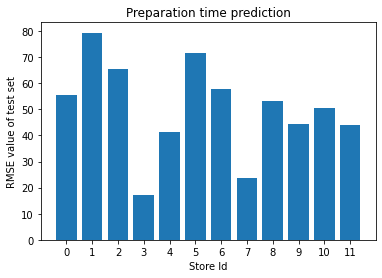

In [25]:
X_t = []
Y_t = []
for j in range(0, len(allStoreIds)):
    xx = []
    yy = []
    for i in range(0, len(X_test)):
        if(X_test[i][j] > 0):
            xx.append(X_test[i])
            yy.append(y_test[i])
    X_t.append(j)
    Y_t.append(getRMSE(yy, regressor.predict(xx)))
    
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.savefig(f'plots/{city}_{month}_1.png')
# plt.show()

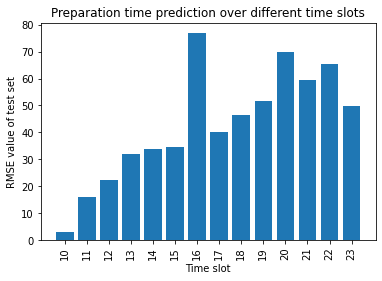

In [26]:
X_Axis = [i for i in range(10, 24)]
RMSETimeSlotWise = {}
total_items = len(allMenuCodes)+len(allStoreIds)
for x in X_Axis:
    x1 = []
    y1 = []
    for i in range(0, len(X_test)):
        if(X_test[i][total_items+x] > 0):
            x1.append(X_test[i])
            y1.append(y_test[i])
    RMSETimeSlotWise[x] = getRMSE(y1, regressor.predict(x1))
    
X_axis = list(RMSETimeSlotWise.keys())
Y_axis = list(RMSETimeSlotWise.values())

plt.bar(X_axis, Y_axis)
plt.xticks(X_axis, rotation='vertical')
plt.xlabel("Time slot")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction over different time slots")
plt.savefig(f'plots/{city}_{month}_2.png')
# plt.show()

In [27]:
Y_t_all = Y_t
# Y_t_all

In [28]:
bakeup_X = X
bakeup_y = y

In [29]:
n = len(allStoreIds)
store_wise_X = [[] for _ in range(n)]
store_wise_y = [[] for _ in range(n)]

for j in range(n):
    for i in range(len(X)):
        if X[i][j] > 0:
            store_wise_X[j].append(X[i][n:])
            store_wise_y[j].append(y[i])

# store_wise_X = [[x for x in X] for j in range(n)]
# store_wise_X = [x for j in range(n) for _,y in zip(X,y) if x[j]>0]

In [30]:
l = []

for i in range(n):
    X = store_wise_X[i]
    y = store_wise_y[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    
#     print("Random Forest Model", i, len(y_train), len(y_test))
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    a = getRMSE(y_train, predictions)
#     print("RMSE score on train set: ", a)
    
    predictions = regressor.predict(X_test)
    b = getRMSE(y_test, predictions)
#     print("RMSE score on test set: ", b)
    l.append((a, b, len(y_train), len(y_test)))
# l

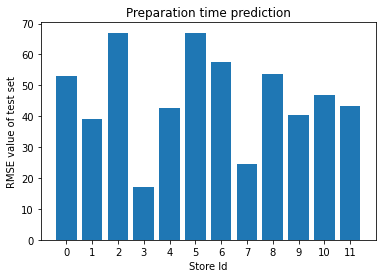

[53.056001936196026,
 38.98053149947499,
 66.91852524845167,
 17.100080915727975,
 42.51973847095802,
 67.03099059072039,
 57.43234089914828,
 24.659834116210238,
 53.67874313568983,
 40.44103537579327,
 46.926836607139904,
 43.217104969921124]

In [31]:
X_t = [i for i in range(len(allStoreIds))]
Y_t = [x[1] for x in l]
Y_t, X_t
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.savefig(f'plots/{city}_{month}_3.png')
# plt.show()
# Y_t

In [42]:
l2 = [(a**2)*b for _,a,_,b in l]
l3 = [b for _,_,_,b in l]
combine_rmse = (sum(l2)/sum(l3))**(1/2)
print("restwise rmse:", combine_rmse)

48.22294420867523

In [44]:
y = []
for i in X_t:
    y.append((Y_t[i], Y_t_all[i]))
#     print(i, Y_t[i], Y_t_all[i])

0 110.73278958157061 118.46762915044431
1 49.32246633110388 46.19214819316697
2 55.37988339949047 78.84432832325724
3 33.465189509275554 33.148221209727005
4 59.11416492174018 60.301924988108524
5 43.10657369954303 48.615090407280086
6 33.47246951146438 34.03093474167357
7 72.4253925848281 59.34757224485053
8 45.76296670557789 48.664450262389366
9 42.63308426676605 50.25310172606236
10 48.302599405662285 48.98357861203935
11 35.90283616130062 40.525496709546886
12 35.454505722680864 43.335434189959194
13 38.54280595325719 49.219792388384555
14 34.767052723558145 40.85527237512303
15 31.738060997397362 32.29103524166308
16 36.74645170966107 34.437496172634745
17 71.65103986158648 59.579805977976385
18 59.67363884805792 63.671188315255904
19 45.93041198512772 48.2129598164105
20 29.756997422734266 36.09697185113681
21 42.62418049051106 38.60470625511067
22 39.31798143555204 43.782416261273916
23 36.76740421345306 37.22711862749954
24 37.41720741610458 50.99678360383393
25 22.365941358295

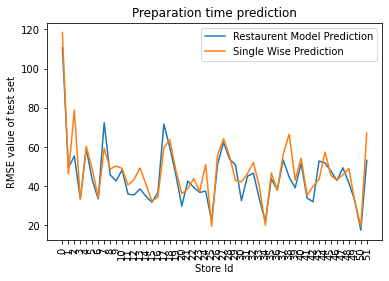

In [48]:
# plt.plot(X_t, Y_t, label = 'Single Model Prediction')
# plt.plot(X_t, Y_t_all, label = 'Restaurent Wise Prediction')

plt.plot(X_t, y)
plt.legend(['Restaurent Model Prediction', 'Single Wise Prediction'])

plt.xticks(X_t, rotation='vertical')
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.savefig(f'plots/{city}_{month}_4.png')
# plt.show()